<a href="https://colab.research.google.com/github/GuilhermeFernandez/TelecomX_2/blob/main/TelecomX2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.datasets import load_occupancy

In [2]:
dados = pd.read_csv('dados_tratados.csv')
dados.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Contas_diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.27
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.80


In [3]:
dados = dados.drop(columns='customerID')

In [4]:
dados.dropna(inplace=True)

# Visualização dos dados

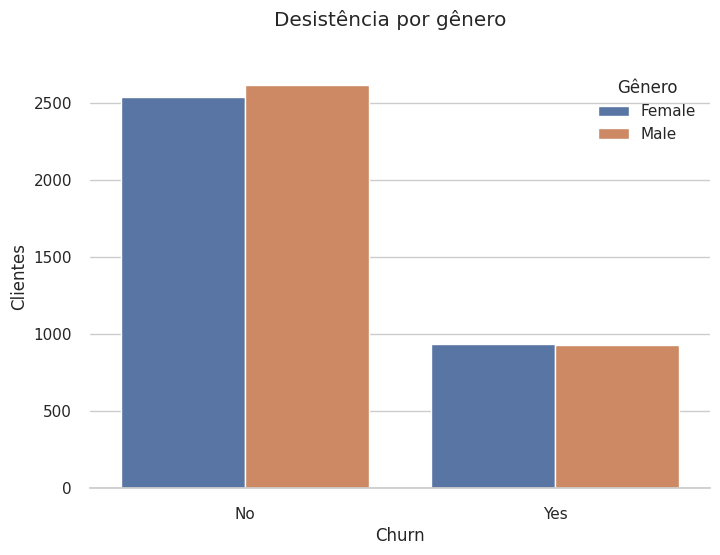

In [5]:
sns.set_theme(style="whitegrid")
p = sns.countplot(dados, x="Churn", hue="gender")
p.figure.suptitle("Desistência por gênero")
p.set_xlabel("Churn")
p.set_ylabel("Clientes")
p.legend(title="Gênero")
sns.despine(left=True, ax=p)

Text(0.5, 0.98, 'Desistência por média de gastos totais e gênero')

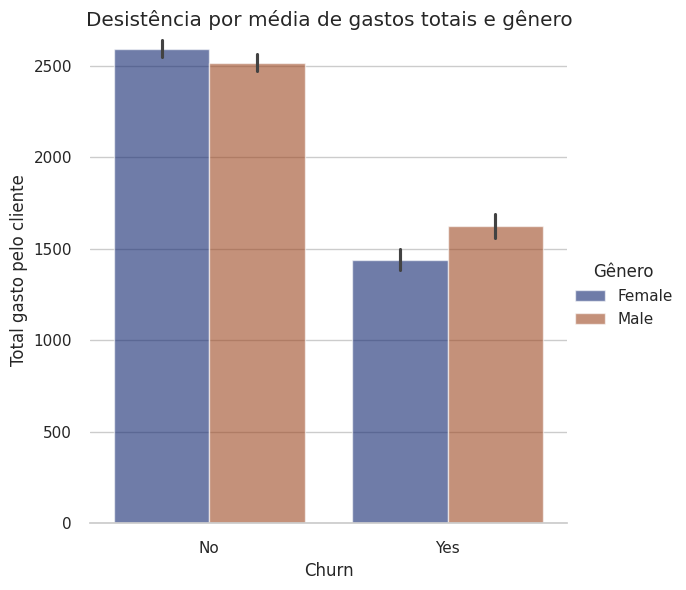

In [6]:
sns.set_theme(style="whitegrid")

p = sns.catplot(
    data=dados, kind="bar",
    x="Churn", y="Charges.Total", hue="gender",
    errorbar="se", palette="dark", alpha=.6, height=6
)
p.despine(left=True)
p.set_axis_labels("Churn", "Total gasto pelo cliente")
p.legend.set_title("Gênero")
p.fig.suptitle("Desistência por média de gastos totais e gênero")

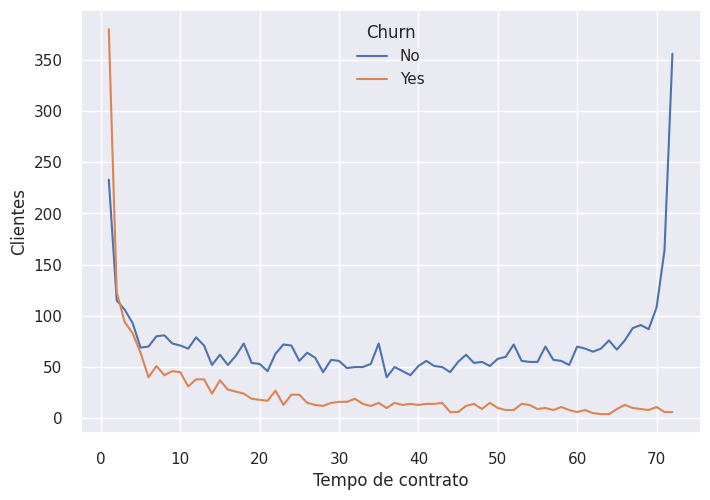

In [7]:
dados_contagem = dados.groupby(['tenure', 'Churn']).size().reset_index(name='quantidade')

sns.set_theme(style="darkgrid")
p = sns.lineplot(
    data=dados_contagem,
    x="tenure",
    y="quantidade",
    hue="Churn"
)
p.set_xlabel("Tempo de contrato")
p.set_ylabel("Clientes")
plt.show()

In [8]:
dados['Churn'] = dados['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [9]:
dados[['Churn', 'Charges.Monthly',	'Charges.Total',	'Contas_diarias']].corr()

,Churn,Charges.Monthly,Charges.Total,Contas_diarias
Churn,1.000000,0.192858,-0.199484,0.192914
Charges.Monthly,0.192858,1.000000,0.651065,0.999996
Charges.Total,-0.199484,0.651065,1.000000,0.651080
Contas_diarias,0.192914,0.999996,0.651080,1.000000


In [10]:
dados = dados.drop(columns='Contas_diarias')

In [11]:
x = dados.drop(columns='Churn')
y = dados['Churn']

#Encoding

In [12]:
colunas = x.columns
one_hot = make_column_transformer((
    OneHotEncoder(drop = 'if_binary'), ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
),
    remainder = 'passthrough',
    sparse_threshold=0)

In [13]:
x = one_hot.fit_transform(x)
colunas = one_hot.get_feature_names_out(colunas)

In [14]:
pd.DataFrame(x, columns=colunas)

,onehotencoder__gender_Male,onehotencoder__SeniorCitizen_1,onehotencoder__Partner_Yes,onehotencoder__Dependents_Yes,onehotencoder__PhoneService_Yes,onehotencoder__MultipleLines_No,onehotencoder__MultipleLines_No phone service,onehotencoder__MultipleLines_Yes,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,...,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,remainder__tenure,remainder__Charges.Monthly,remainder__Charges.Total
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,65.60,593.30
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,59.90,542.40
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,73.90,280.85
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,13.0,98.00,1237.85
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,55.15,742.90
7028,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,22.0,85.10,1873.70
7029,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,50.30,92.75
7030,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,67.0,67.85,4627.65


In [15]:
label_encoder = LabelEncoder()
y  = label_encoder.fit_transform(y)

# Treino e Teste

In [16]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, random_state=2226)

# Normalização

In [17]:
scaler = StandardScaler()

In [18]:
x_treino_normalizado = scaler.fit_transform(x_treino)
x_teste_normalizado = scaler.transform(x_teste)

# Dummy

In [19]:
dummy = DummyClassifier(random_state=2226)

In [20]:
dummy.fit(x_treino_normalizado, y_treino)

DummyClassifier(random_state=2226)

In [21]:
dummy.score(x_teste_normalizado, y_teste)

0.7343572241183163

# Árvore de Decisão

In [22]:
tree = DecisionTreeClassifier(random_state=2226)

In [23]:
tree.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=2226)

In [24]:
tree.score(x_teste, y_teste)

0.7275312855517634

In [25]:
tree.score(x_treino, y_treino)

0.9981039059537353

## Visualizando importância das Features (seleção)

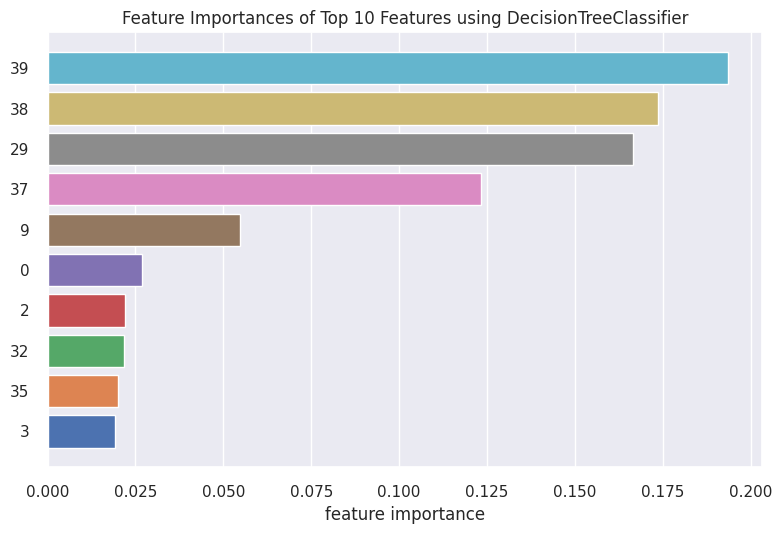

<Axes: title={'center': 'Feature Importances of Top 10 Features using DecisionTreeClassifier'}, xlabel='feature importance'>

In [26]:
viz = FeatureImportances(tree, relative=False, topn=10)
viz.fit(x_treino, y_treino)
viz.show()

In [27]:
importances = tree.feature_importances_

feature_importances = pd.DataFrame({'Features': colunas, 'Importances': importances})
feature_importances.sort_values('Importances', ascending=False)

,Features,Importances
39,remainder__Charges.Total,0.193628
38,remainder__Charges.Monthly,0.173705
29,onehotencoder__Contract_Month-to-month,0.166593
37,remainder__tenure,0.123347
9,onehotencoder__InternetService_Fiber optic,0.054782
0,onehotencoder__gender_Male,0.026778
2,onehotencoder__Partner_Yes,0.022083
32,onehotencoder__PaperlessBilling_Yes,0.021726
35,onehotencoder__PaymentMethod_Electronic check,0.019978
3,onehotencoder__Dependents_Yes,0.019250


## Relatório de Classificação e Seleção de variáveis

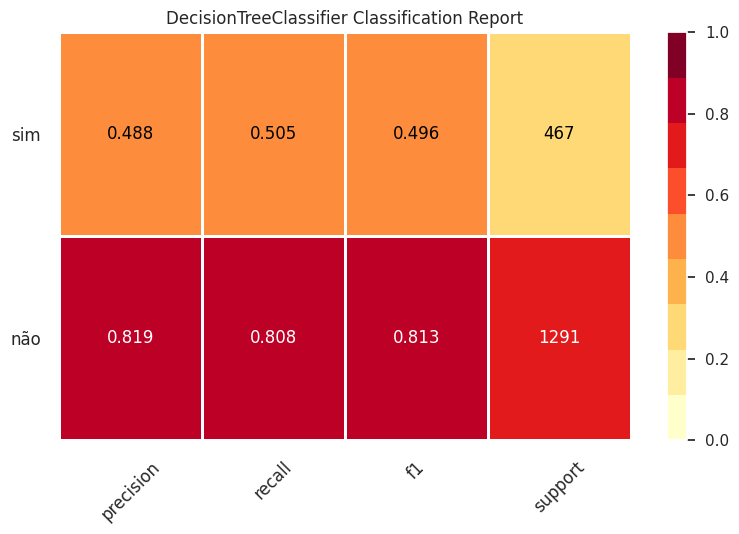

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [28]:
classes = ["não", "sim"]
visualizer = ClassificationReport(tree, classes=classes, support=True)

visualizer.fit(x_treino, y_treino)        # Fit the visualizer and the model
visualizer.score(x_teste, y_teste)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

precision
Precision can be seen as a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

recall
Recall is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances. For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

f1 score
The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

support
Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [29]:
resultados_df = pd.DataFrame(index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim','Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'])

x_treino__df = pd.DataFrame(x_treino, columns=colunas)
x_teste__df = pd.DataFrame(x_teste, columns=colunas)

for count in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    selected_features = feature_importances['Features'].values[:count]

    x_treino_selecionado = x_treino__df[selected_features]
    x_teste_selecionado = x_teste__df[selected_features]

    tree.fit(x_treino_selecionado, y_treino)

    y_pred = tree.predict(x_teste_selecionado)

    metricas = classification_report(y_teste, y_pred, target_names=classes, output_dict=True)

    # Extrair as métricas para a classe 'sim' e 'não' (churn)
    precision_sim = metricas['sim']['precision']
    recall_sim = metricas['sim']['recall']
    f1_sim = metricas['sim']['f1-score']
    support_sim = metricas['sim']['support']
    precision_não = metricas['não']['precision']
    recall_não = metricas['não']['recall']
    f1_não = metricas['não']['f1-score']
    support_não = metricas['não']['support']

    resultados_df[count] = [precision_sim, recall_sim, f1_sim, support_sim, precision_não, recall_não, f1_não, support_não]

resultados_df

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,1,5,10,15,20,25,30,35,40,45,50
Precisão_sim,0.000000,0.250000,0.554878,0.530744,0.539519,0.496000,0.505155,0.452785,0.487603,0.487603,0.487603
Recall_sim,0.000000,0.002141,0.194861,0.351178,0.336188,0.398287,0.419700,0.400428,0.505353,0.505353,0.505353
F1-Score_sim,0.000000,0.004246,0.288431,0.422680,0.414248,0.441805,0.458480,0.425000,0.496320,0.496320,0.496320
Suporte_sim,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
Precisão_não,0.734357,0.734322,0.764115,0.790890,0.788684,0.796819,0.802190,0.791822,0.818681,0.818681,0.818681
Recall_não,1.000000,0.997676,0.943455,0.887684,0.896204,0.853602,0.851278,0.824942,0.807901,0.807901,0.807901
F1-Score_não,0.846835,0.845977,0.844367,0.836496,0.839014,0.824233,0.826005,0.808042,0.813255,0.813255,0.813255
Suporte_não,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000


In [30]:
resultados_df = pd.DataFrame(index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim','Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'])

x_treino__df = pd.DataFrame(x_treino, columns=colunas)
x_teste__df = pd.DataFrame(x_teste, columns=colunas)

for count in range(35,41):
    selected_features = feature_importances['Features'].values[:count]

    x_treino_selecionado = x_treino__df[selected_features]
    x_teste_selecionado = x_teste__df[selected_features]

    tree.fit(x_treino_selecionado, y_treino)

    y_pred = tree.predict(x_teste_selecionado)

    metricas = classification_report(y_teste, y_pred, target_names=classes, output_dict=True)

    # Extrair as métricas para a classe 'sim' e 'não' (churn)
    precision_sim = metricas['sim']['precision']
    recall_sim = metricas['sim']['recall']
    f1_sim = metricas['sim']['f1-score']
    support_sim = metricas['sim']['support']
    precision_não = metricas['não']['precision']
    recall_não = metricas['não']['recall']
    f1_não = metricas['não']['f1-score']
    support_não = metricas['não']['support']

    resultados_df[count] = [precision_sim, recall_sim, f1_sim, support_sim, precision_não, recall_não, f1_não, support_não]

resultados_df

,35,36,37,38,39,40
Precisão_sim,0.452785,0.446429,0.442130,0.507726,0.488223,0.487603
Recall_sim,0.400428,0.428266,0.408994,0.492505,0.488223,0.505353
F1-Score_sim,0.425000,0.437158,0.424917,0.500000,0.488223,0.496320
Suporte_sim,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
Precisão_não,0.791822,0.796183,0.791855,0.818391,0.814872,0.818681
Recall_não,0.824942,0.807901,0.813323,0.827266,0.814872,0.807901
F1-Score_não,0.808042,0.801999,0.802446,0.822804,0.814872,0.813255
Suporte_não,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000


In [31]:
feature_selecionada = feature_importances['Features'].values[:38]

x_df = pd.DataFrame(x, columns=colunas)
x_feature_selecionada = x_df[feature_selecionada]

## Realizando nova modelagem

In [32]:
x_treino_dt, x_teste_dt, y_treino_dt, y_teste_dt = train_test_split(x_feature_selecionada, y, stratify=y, random_state=2226)

In [33]:
tree.fit(x_treino_dt, y_treino_dt)

DecisionTreeClassifier(random_state=2226)

In [34]:
tree.score(x_teste_dt, y_teste_dt)

0.7383390216154722

In [35]:
tree.score(x_treino_dt, y_treino_dt)

0.981039059537353

Valores subiram marginalmente, mas provavelmente ganhou performance (diminuiu colunas desnecessárias)

## Otimizando os parâmetros

In [36]:
param_grid = {
      'max_depth': [3, 5, 7, 9, 11],
      'min_samples_leaf': [1, 2, 3],
      'min_samples_split': [2, 3],
      'random_state': [2226]
 }

In [37]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2226)

model_grid = GridSearchCV(DecisionTreeClassifier(random_state=2226), param_grid=param_grid,
             scoring='f1', cv=cv)

model_grid.fit(x_treino_dt, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2226, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=2226),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3], 'random_state': [2226]},
             scoring='f1')

In [38]:
model_grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 2226}

##Avaliação Final

In [39]:
y_pred_dt = model_grid.best_estimator_.predict(x_teste_dt)
metricas = classification_report(y_teste, y_pred_dt, target_names=classes, output_dict=True)

precision_sim = metricas['sim']['precision']
recall_sim = metricas['sim']['recall']
f1_sim = metricas['sim']['f1-score']
support_sim = metricas['sim']['support']
precision_não = metricas['não']['precision']
recall_não = metricas['não']['recall']
f1_não = metricas['não']['f1-score']
support_não = metricas['não']['support']
resultados_final = [
    precision_sim, recall_sim, f1_sim, support_sim,
    precision_não, recall_não, f1_não, support_não
]

resultados_final_df = pd.DataFrame(
    resultados_final,
    index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim',
           'Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'],
    columns=['Métricas do Modelo Otimizado']
)

resultados_final_df

,Métricas do Modelo Otimizado
Precisão_sim,0.588235
Recall_sim,0.578158
F1-Score_sim,0.583153
Suporte_sim,467.000000
Precisão_não,0.848345
Recall_não,0.853602
F1-Score_não,0.850965
Suporte_não,1291.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


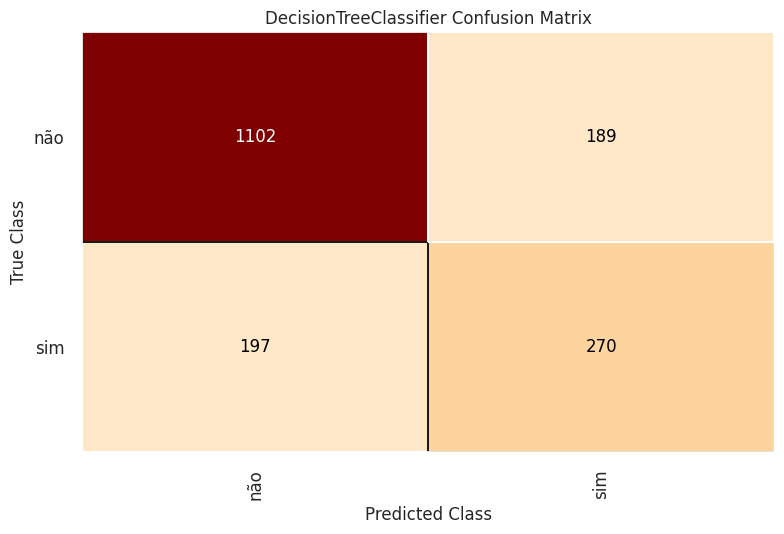

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [40]:
viz = ConfusionMatrix(model_grid.best_estimator_, classes=classes, support=True, cmap='OrRd')
viz.fit(x_treino_dt, y_treino)
viz.score(x_teste_dt, y_teste)
viz.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

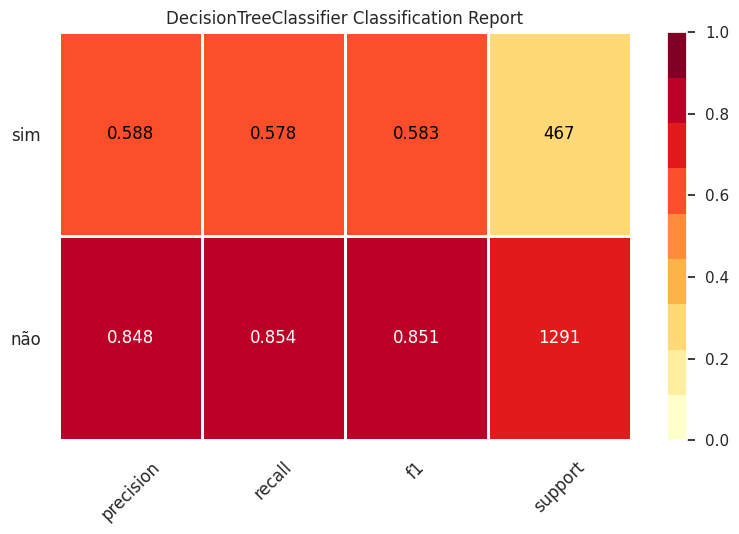

In [41]:
visualizer = ClassificationReport(model_grid.best_estimator_, classes=classes, support=True)

visualizer.fit(x_treino_dt, y_treino)
visualizer.score(x_teste_dt, y_teste)
visualizer.show(outpath="relatorio_DT.png")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


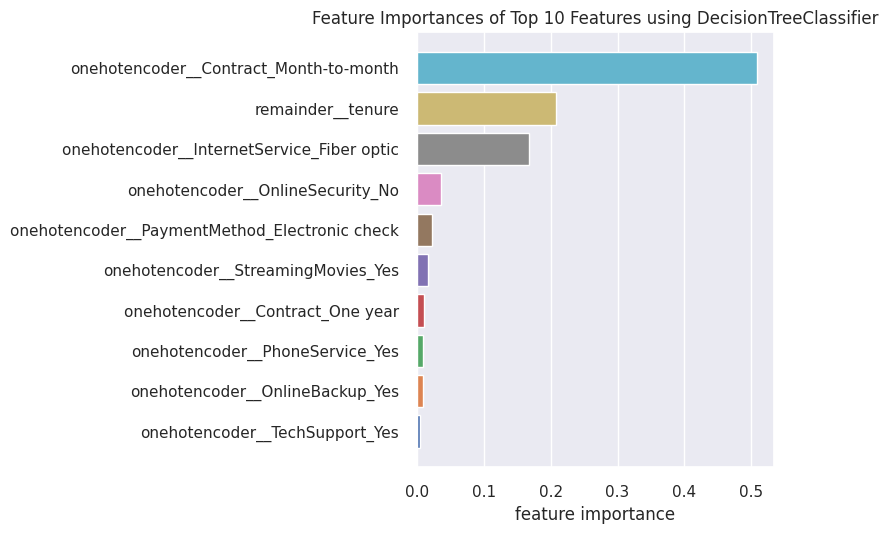

<Axes: title={'center': 'Feature Importances of Top 10 Features using DecisionTreeClassifier'}, xlabel='feature importance'>

In [42]:
viz = FeatureImportances(model_grid.best_estimator_, relative=False, topn=10)
viz.fit(x_treino_dt, y_treino_dt)
viz.show()

In [43]:
importances = model_grid.best_estimator_.feature_importances_

feature_importances = pd.DataFrame({'Features': feature_selecionada, 'Importances': importances})
feature_importances.sort_values('Importances', ascending=False)

,Features,Importances
29,onehotencoder__Contract_Month-to-month,0.508464
37,remainder__tenure,0.208519
9,onehotencoder__InternetService_Fiber optic,0.167203
11,onehotencoder__OnlineSecurity_No,0.036728
35,onehotencoder__PaymentMethod_Electronic check,0.021978
28,onehotencoder__StreamingMovies_Yes,0.016725
30,onehotencoder__Contract_One year,0.010525
4,onehotencoder__PhoneService_Yes,0.008898
16,onehotencoder__OnlineBackup_Yes,0.008396
22,onehotencoder__TechSupport_Yes,0.005124


##Exportação Modelo Decision Tree

In [44]:
try:
  with open('model_churn_dt.pkl', 'wb') as file:
    pickle.dump(model_grid.best_estimator_, file)
  print('Modelo salvo com sucesso!!!')
except Exception as e:
  print('Ocorreu um erro ao salvar o modelo: ', str(e))

Modelo salvo com sucesso!!!


#KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
knn = KNeighborsClassifier()

In [47]:
knn.fit(x_treino_normalizado, y_treino)

KNeighborsClassifier()

In [48]:
knn.score(x_teste_normalizado, y_teste)

0.7491467576791809

In [49]:
knn.score(x_treino_normalizado, y_treino)

0.8376943496397421

## Visualizando importância das Features

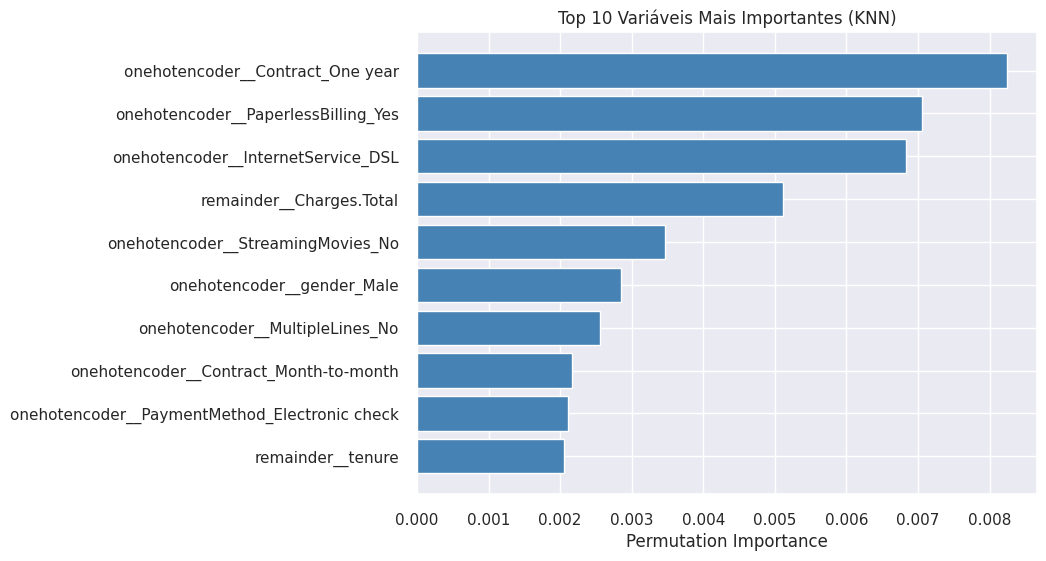

In [50]:
# Calculate permutation importance
result = permutation_importance(knn, x_teste_normalizado, y_teste, n_repeats=10, random_state=2226)

importancias_series = pd.Series(result.importances_mean, index=colunas)
top_10 = importancias_series.sort_values(ascending=False).head(10)
top_10 = top_10.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_10.index, top_10.values, color='steelblue')
plt.xlabel('Permutation Importance')
plt.title('Top 10 Variáveis Mais Importantes (KNN)')
plt.show()

## Relatório de Classificação e Seleção de variáveis

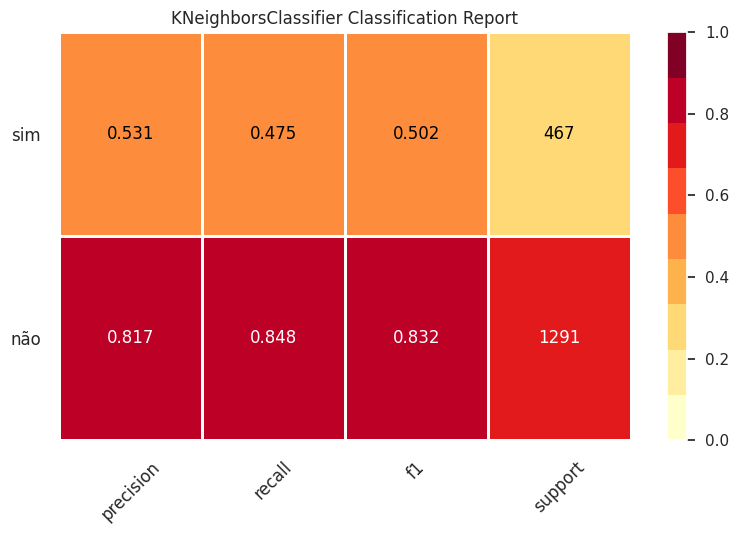

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [51]:
classes = ["não", "sim"]
visualizer = ClassificationReport(knn, classes=classes, support=True)

visualizer.fit(x_treino_normalizado, y_treino)        # Fit the visualizer and the model
visualizer.score(x_teste_normalizado, y_teste)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

## Otimizando os parâmetros

In [52]:
param_grid = {
      'n_neighbors': [5, 7, 9,10],
      'weights': ['uniform', 'distance']
 }

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2226)

model_grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid,
             scoring='f1', cv=cv)

model_grid.fit(x_treino_normalizado, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2226, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 7, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [55]:
model_grid.best_params_

{'n_neighbors': 9, 'weights': 'uniform'}

##Avaliação Final

In [56]:
y_pred_knn = model_grid.best_estimator_.predict(x_teste_normalizado)
metricas = classification_report(y_teste, y_pred_knn, target_names=classes, output_dict=True)

precision_sim = metricas['sim']['precision']
recall_sim = metricas['sim']['recall']
f1_sim = metricas['sim']['f1-score']
support_sim = metricas['sim']['support']
precision_não = metricas['não']['precision']
recall_não = metricas['não']['recall']
f1_não = metricas['não']['f1-score']
support_não = metricas['não']['support']
resultados_final = [
    precision_sim, recall_sim, f1_sim, support_sim,
    precision_não, recall_não, f1_não, support_não
]

resultados_final_df = pd.DataFrame(
    resultados_final,
    index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim',
           'Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'],
    columns=['Métricas do Modelo Otimizado']
)

print(resultados_final_df)

              Métricas do Modelo Otimizado
Precisão_sim                      0.549261
Recall_sim                        0.477516
F1-Score_sim                      0.510882
Suporte_sim                     467.000000
Precisão_não                      0.819527
Recall_não                        0.858249
F1-Score_não                      0.838441
Suporte_não                    1291.000000


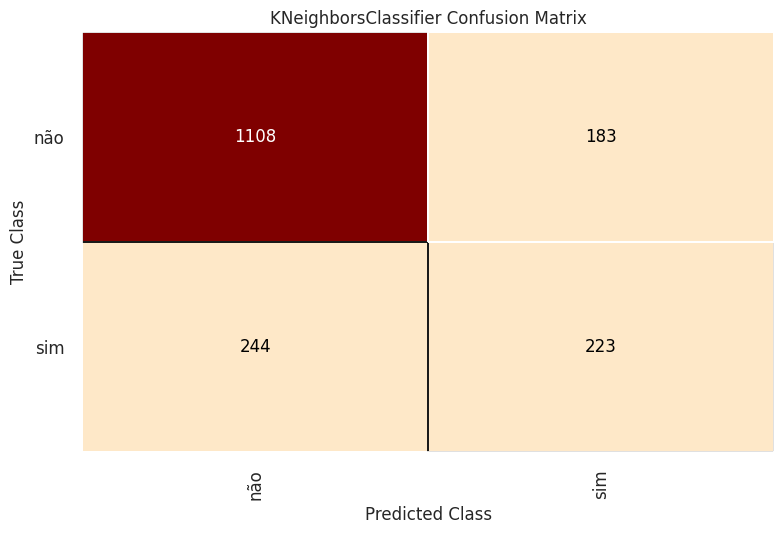

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [57]:
viz = ConfusionMatrix(model_grid.best_estimator_, classes=classes, support=True, cmap='OrRd')
viz.fit(x_treino_normalizado, y_treino)
viz.score(x_teste_normalizado, y_teste)
viz.show()

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

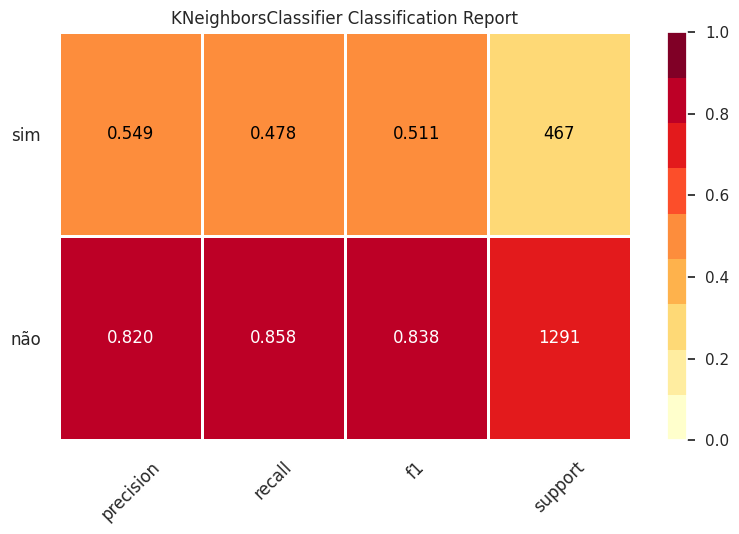

In [58]:
visualizer = ClassificationReport(model_grid.best_estimator_, classes=classes, support=True)

visualizer.fit(x_treino_normalizado, y_treino)
visualizer.score(x_teste_normalizado, y_teste)
visualizer.show(outpath="relatorio_KNN.png")

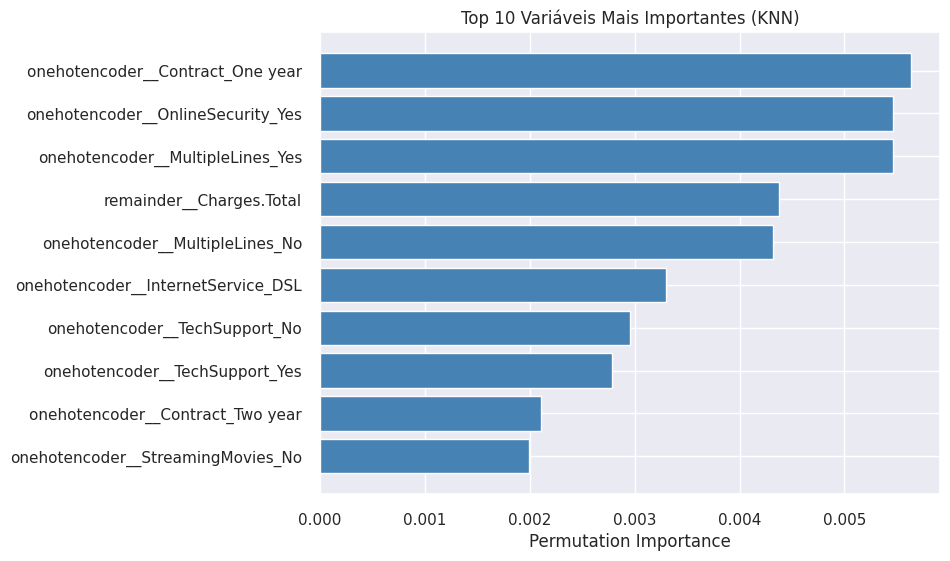

In [59]:
# Calculate permutation importance
result = permutation_importance(model_grid.best_estimator_, x_teste_normalizado, y_teste, n_repeats=10, random_state=2226)

importancias_series = pd.Series(result.importances_mean, index=colunas)
top_10 = importancias_series.sort_values(ascending=False).head(10)
top_10 = top_10.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_10.index, top_10.values, color='steelblue')
plt.xlabel('Permutation Importance')
plt.title('Top 10 Variáveis Mais Importantes (KNN)')
plt.show()

##Exportando Modelo KNN

In [60]:
try:
  with open('model_churn_knn.pkl', 'wb') as file:
    pickle.dump(model_grid.best_estimator_, file)
  print('Modelo salvo com sucesso!!!')
except Exception as e:
  print('Ocorreu um erro ao salvar o modelo: ', str(e))

Modelo salvo com sucesso!!!


# Relatório Final

(explicar o pq de cada modelo e pq normalizou)

Qual modelo teve o melhor desempenho?

Algum modelo apresentou overfitting ou underfitting? Se sim, considere as possíveis causas e ajustes:

Overfitting: Quando o modelo aprende demais sobre os dados de treino, perdendo a capacidade de generalizar para novos dados. Considere reduzir a complexidade do modelo ou aumentar os dados de treino.

Underfitting: Quando o modelo não captura bem as tendências dos dados, indicando que está muito simples. Tente aumentar a complexidade do modelo ou ajustar seus parâmetros.




Após escolher os modelos, realize a análise das variáveis mais relevantes para a previsão de evasão:

Regressão Logística:  investigue os coeficientes das variáveis, que mostram sua contribuição para a previsão de evasão.

KNN (K-Nearest Neighbors): Observe como os vizinhos mais próximos influenciam a decisão de classificação. As variáveis mais impactantes podem ser aquelas que mais contribuem para a proximidade entre os pontos de dados.